## Poisson Distribution of Passing Touchdowns

In [134]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

seasons = range (2018, 2024 + 1)
pbp_py =\
    nfl.import_pbp_data(seasons)

pbp_py_pass =\
    pbp_py\
    .query('passer_id.notnull()')\
    .reset_index()

2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


In [144]:
## replace null or NA values for passing touchdowns and passers
pbp_py_pass\
    .loc[pbp_py_pass.pass_touchdown.isnull(), 'pass_touchdown'] = 0

pbp_py_pass\
    .loc[pbp_py_pass.passer.isnull(), 'passer'] = 'none'

pbp_py_pass\
    .loc[pbp_py_pass.passer_id.isnull(), 'passer_id'] = 'none'

pbp_py_pass_td_y =\
    pbp_py_pass\
    .groupby( ['season', 'passer', 'passer_id', 'week'])\
    .agg({'pass_touchdown': ['sum'],
         'total_line': ['count', 'mean']})

##condense and rename columns
pbp_py_pass_td_y.columns =\
    list(map('_'.join, pbp_py_pass_td_y.columns))

pbp_py_pass_td_y.reset_index(inplace = True)

pbp_py_pass_td_y\
    .rename(columns ={'pass_touchdown_sum': 'pass_td_y',
                     'total_line_mean': 'total_line',
                     'total_line_count': 'n_passes'},
           inplace = True)

## get just the QBs with more than 10 passes
pbp_py_pass_td_y =\
    pbp_py_pass_td_y\
    .query('n_passes >= 10')

pbp_py_pass_td_y\
    .groupby('pass_td_y')\
    .agg({'n_passes': 'count'})

,n_passes
pass_td_y,
0.0,946
1.0,1312
2.0,1073
3.0,482
4.0,176
5.0,38
6.0,4


## Bar Graph of Probabilities

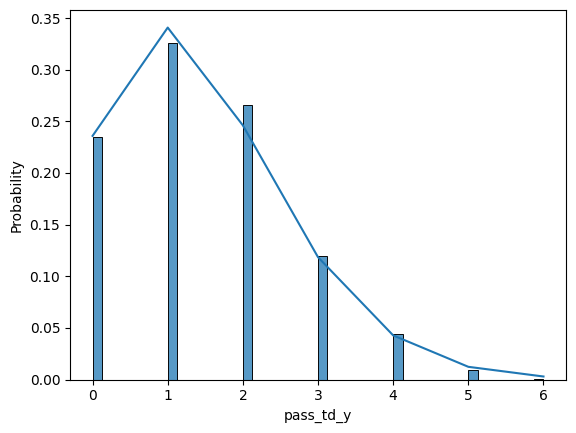

In [145]:
## Create a poisson distribution of mean TD passes
pass_td_y_mean_py =\
    pbp_py_pass_td_y\
    .pass_td_y.mean()

plot_pos_py =\
    pd.DataFrame(
    {'x': range(0,7),
    'expected': [poisson.pmf(x, pass_td_y_mean_py) for x in range(0,7)]
    }
)

sns.histplot(pbp_py_pass_td_y['pass_td_y'], stat = 'probability')
plt.plot(plot_pos_py.x, plot_pos_py.expected)
plt.show()

## Individual Player Markets and Modeling

In [146]:
## pass_ty_d greater than or equal to 10 per week
pbp_py_pass_td_y_geq10 =\
    pbp_py_pass_td_y.query('n_passes >= 10')

## take average touchdown passes for each QB for previous season and current season up to the current game
x_py = pd.DataFrame()
for season_idx in range(2018, 2024 + 1):
    for week_idx in range(1, 22 + 1):
        week_calc_py = (
            pbp_py_pass_td_y_geq10
                .query("(season == " + str(season_idx - 1) + ") | "
                        "(season ==" + str(season_idx) + "& week < " + str(week_idx) + ")")
            .groupby(['passer_id', 'passer'])
            .agg({'pass_td_y': ['count', 'mean']})
    )
        
    week_calc_py.columns =\
        list(map('_'.join, week_calc_py.columns))
    week_calc_py.reset_index(inplace = True)
    week_calc_py\
        .rename(columns ={
            'pass_td_count': 'n_games',
            'pass_td_y_mean': 'pass_td_rate'},
            inplace = True)
    week_calc_py['season'] = season_idx
    week_calc_py['week'] = week_idx
    x_py = pd.concat([x_py, week_calc_py])
    
## Choose a specific QB to look at
x_py.query('passer == "P.Mahomes"').tail()

,passer_id,passer,pass_td_y_count,pass_td_rate,season,week
53,00-0033873,P.Mahomes,35,2.228571,2020,22
50,00-0033873,P.Mahomes,38,2.368421,2021,22
40,00-0033873,P.Mahomes,39,2.384615,2022,22
35,00-0033873,P.Mahomes,39,2.025641,2023,22
29,00-0033873,P.Mahomes,36,1.638889,2024,22


In [193]:
pbp_py_pass_td_y_geq10=\
    pbp_py_pass_td_y.query("n_passes >= 10")

x_py = pd.DataFrame()
for season_idx in range(2018, 2024 + 1):
    for week_idx in range(1, 22 + 1):
        week_calc_py = (
            pbp_py_pass_td_y_geq10\
                .query("(season == " +
                       str(season_idx - 1) +
                       ") | " +
                       "(season == " +
                       str(season_idx) +
                       "&" +
                       "week < " +
                       str(week_idx) +
                       ")")\
            .groupby(["passer_id", "passer"])\
            .agg({"pass_td_y": ["count", "mean"]})
        )
        week_calc_py.columns =\
            list(map("_".join, week_calc_py.columns))
        week_calc_py.reset_index(inplace = True)
        week_calc_py\
            .rename(columns ={
                "pass_td_y_count": "n_games",
                "pass_td_y_mean": "pass_td_rate"},
            inplace = True)
        week_calc_py["season"] = season_idx
        week_calc_py["week"] = week_idx
        x_py = pd.concat([x_py, week_calc_py])
        
pd.set_option('display.max_rows', None)       
print(x_py.query('passer == "P.Mahomes"'))

     passer_id     passer  n_games  pass_td_rate  season  week
30  00-0033873  P.Mahomes        1      4.000000    2018     2
30  00-0033873  P.Mahomes        2      5.000000    2018     3
31  00-0033873  P.Mahomes        3      4.333333    2018     4
32  00-0033873  P.Mahomes        4      3.500000    2018     5
32  00-0033873  P.Mahomes        5      2.800000    2018     6
33  00-0033873  P.Mahomes        6      3.000000    2018     7
35  00-0033873  P.Mahomes        7      3.142857    2018     8
35  00-0033873  P.Mahomes        8      3.250000    2018     9
36  00-0033873  P.Mahomes        9      3.222222    2018    10
38  00-0033873  P.Mahomes       10      3.100000    2018    11
39  00-0033873  P.Mahomes       11      3.363636    2018    12
41  00-0033873  P.Mahomes       11      3.363636    2018    13
42  00-0033873  P.Mahomes       12      3.416667    2018    14
43  00-0033873  P.Mahomes       13      3.307692    2018    15
44  00-0033873  P.Mahomes       14      3.214286    201

In [196]:
## Create a response variable
pbp_py_pass_td_y_geq10 =\
    pbp_py_pass_td_y_geq10.query('season != 2017')\
    .merge(x_py, 
              on = ['season', 'week', 'passer_id', 'passer'],
              how = 'inner')

## fit the model using a Poisson regression
pass_fit_py =\
    smf.glm(
        formula = 'pass_td_y ~ pass_td_rate + total_line',
        data = pbp_py_pass_td_y_geq10,
        family = sm.families.Poisson())\
    .fit()

pbp_py_pass_td_y_geq10['exp_pass_td'] =\
    pass_fit_py\
    .predict()

print(pass_fit_py.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              pass_td_y   No. Observations:                 3854
Model:                            GLM   Df Residuals:                     3851
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5659.6
Date:                Thu, 09 Jan 2025   Deviance:                       3951.4
Time:                        15:16:55   Pearson chi2:                 3.28e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07302
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.0665      0.136     -7.862   

In [197]:
## Compare data from a specific game to the model
filter_by = 'passer == "P.Mahomes" & season == 2022 & week == 22'
cols_look =[
    'season', 
    'week', 
    'passer',
    'total_line',
    'n_games',
    'pass_td_rate',
    'exp_pass_td',
]

pbp_py_pass_td_y_geq10.query(filter_by)[cols_look]

,season,week,passer,total_line,n_games,pass_td_rate,exp_pass_td
2583,2022,22,P.Mahomes,51.0,39,2.384615,2.072438


In [200]:
## so we can see Mahomes was expected to through fewer than 2.5 TDs, but what is the probability of each outcome?
pbp_py_pass_td_y_geq10['p_0_td'] =\
    poisson.pmf(k=0,
               mu = pbp_py_pass_td_y_geq10['exp_pass_td'])

pbp_py_pass_td_y_geq10['p_1_td'] =\
    poisson.pmf(k=1,
               mu = pbp_py_pass_td_y_geq10['exp_pass_td'])

pbp_py_pass_td_y_geq10['p_2_td'] =\
    poisson.pmf(k=2,
               mu = pbp_py_pass_td_y_geq10['exp_pass_td'])

pbp_py_pass_td_y_geq10['p_g2_td'] =\
    1 - poisson.cdf(k=2,
               mu = pbp_py_pass_td_y_geq10['exp_pass_td'])

filter_by = 'passer == "P.Mahomes" & season == 2022 & week == 22'
cols_look =[
    'passer',
    'total_line',
    'n_games',
    'pass_td_rate',
    'exp_pass_td',
    'p_0_td',
    'p_1_td',
    'p_2_td',
    'p_g2_td'
]

pbp_py_pass_td_y_geq10.query(filter_by)[cols_look]

,passer,total_line,n_games,pass_td_rate,exp_pass_td,p_0_td,p_1_td,p_2_td,p_g2_td
2583,P.Mahomes,51.0,39,2.384615,2.072438,0.125878,0.260875,0.270324,0.342922


## Poisson Regression Coefficients

In [204]:
from scipy.stats import poisson

x = poisson.rvs(mu =1, size = 10)
print(x)
print(x.mean())

[1 2 2 0 0 0 0 1 0 1]
0.7


In [210]:
## fit a GLM with an intercept and look at the coefficient on the model scale
df_py = pd.DataFrame({'x': x})

glm_out_py =\
    smf.glm(formula = 'x ~ 1', data = df_py, family = sm.families.Poisson()).fit()

print(glm_out_py.params)
print(np.exp(glm_out_py.params))

Intercept   -0.356675
dtype: float64
Intercept    0.7
dtype: float64


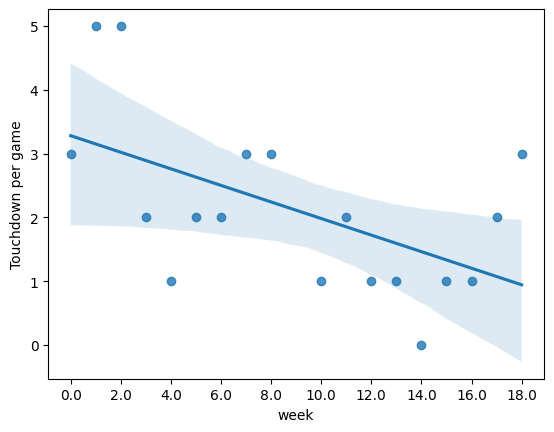

In [222]:
## how does this data look in a specific example?
bal_td_py = (
    pbp_py\
    .query('posteam == "BAL" & season == 2022')
    .groupby(['game_id', 'week'])
    .agg({'touchdown': ['sum']})
)

##reformat columns
bal_td_py.columns = list(map('_'.join, bal_td_py.columns))
bal_td_py.reset_index(inplace = True)

##shift week back 1 so the first week of the season starts at 0
bal_td_py['week'] = bal_td_py['week'] - 1

weeks_plot = np.linspace(start = 0, stop = 18, num = 10)

ax = sns.regplot(data = bal_td_py, x = 'week', y = 'touchdown_sum')
ax.set_xticks(ticks = weeks_plot, labels = weeks_plot)
plt.xlabel('week')
plt.ylabel('Touchdown per game')
plt.show()

In [225]:
## look at coefficients of the model
glm_bal_td_py =\
    smf.glm(formula = 'touchdown_sum ~ week',
            data = bal_td_py,
            family = sm.families.Poisson())\
        .fit()

print(glm_bal_td_py.params)
print(np.exp(glm_bal_td_py.params))

Intercept    1.253350
week        -0.063162
dtype: float64
Intercept    3.502055
week         0.938791
dtype: float64


In [ ]:
##The incercept is the expected number of TDs in the first week and the week value would be put in the equation
    ## (intercept X week^week number)